## 1. Consulta y descarga en PubMed
ENTORNO (biobert_transformers)
Se utiliza la API de Entrez (NCBI) para buscar artículos científicos relacionados con "antibiotics adverse effects". Primero se consulta el número total de artículos disponibles. Se descargan hasta 1000 artículos en bloques de 100 y se extraen los resúmenes (abstracts) disponibles en formato MEDLINE.

In [1]:
from Bio import Entrez, Medline
import pandas as pd

Entrez.email = "ajarjrinjurado@hotmail.com"  # IMPORTANTE: tu correo válido para NCBI

# acotar búsqueda
search_term = "amoxicillin"

# consultar numero de articulos
handle = Entrez.esearch(db="pubmed", term=search_term, retmode="xml")
record = Entrez.read(handle)
total_results = int(record["Count"])
print(f"Total de artículos encontrados en PubMed sobre '{search_term}': {total_results}")

# aumentar a 1000 articulos, descargar en bloques de 100
all_ids = []
retmax = 100
print("\nIniciando descarga de IDs...")
for start in range(0, 1000, retmax):
    handle = Entrez.esearch(db="pubmed", term=search_term, retstart=start, retmax=retmax)
    record = Entrez.read(handle)
    all_ids.extend(record["IdList"])
    print(f"Descargados IDs del {start} al {start + retmax}")

print("\nPMIDs guardados.")
print("Descargando abstracts...")
handle = Entrez.efetch(db="pubmed", id=",".join(all_ids), rettype="medline", retmode="text")
records = list(Medline.parse(handle))

abstracts = []
ids_finales = []
anios = []

for r in records:
    if "AB" in r:
        abstracts.append(r.get("AB"))
        ids_finales.append(r.get("PMID", "N/A"))
        dp = r.get("DP", "")
        anio = int(dp[:4]) if dp[:4].isdigit() else None
        anios.append(anio)

print(f"\nTotal de abstracts obtenidos: {len(abstracts)}")

df = pd.DataFrame({
    "PMID": ids_finales,
    "year": anios,
    "abstract": abstracts
})

df.to_csv("abstracts_amoxicillin.csv", index=False)
print("\nArchivo guardado: abstracts_amoxicillin.csv")


Total de artículos encontrados en PubMed sobre 'amoxicillin': 26551

Iniciando descarga de IDs...
Descargados IDs del 0 al 100
Descargados IDs del 100 al 200
Descargados IDs del 200 al 300
Descargados IDs del 300 al 400
Descargados IDs del 400 al 500
Descargados IDs del 500 al 600
Descargados IDs del 600 al 700
Descargados IDs del 700 al 800
Descargados IDs del 800 al 900
Descargados IDs del 900 al 1000

PMIDs guardados.
Descargando abstracts...

Total de abstracts obtenidos: 987

Archivo guardado: abstracts_amoxicillin.csv


## 2. Preprocesamiento de Texto
Se realiza limpieza textual incluyendo conversión a minúsculas, eliminación de puntuación, tokenización y eliminación de palabras vacías (stopwords) usando NLTK.

In [2]:
# se realiza el preprocesamiento
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os

# Ruta compatible multiplataforma (Linux/macOS/Windows)
nltk_data_path = os.path.expanduser("~/nltk_data")
nltk.data.path.append(nltk_data_path)

# Descargar recursos solo si faltan
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', download_dir=nltk_data_path)

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', download_dir=nltk_data_path)

# Función de limpieza de texto
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"[^a-záéíóúñ ]", "", texto)
    tokens = word_tokenize(texto)

    # Stopwords extendidas
    stopwords_extra = set(stopwords.words('english'))
    stopwords_extra.update([
        "background", "objective", "methods", "purpose", "p", 
        "conclusion", "introduction", "result", "results", "study"
    ])

    tokens = [t for t in tokens if t not in stopwords_extra]
    return tokens

print("Preprocesamiento listo ✅")

Preprocesamiento listo ✅


## 3. Aplicación del Preprocesamiento
Se aplica la función de limpieza a cada abstract, generando una lista de tokens por documento (`tokens_por_abstract`).

In [3]:
# aplicamos el preprocesamiento
tokens_por_abstract = [limpiar_texto(ab) for ab in abstracts]
print(tokens_por_abstract[0][:20])

['vitro', 'meropenem', 'shown', 'restore', 'activity', 'rifampicin', 'rifampicinresistant', 'mycobacterium', 'tuberculosis', 'strains', 'phase', 'trial', 'aimed', 'determine', 'addition', 'rifampicin', 'increases', 'early', 'bactericidal', 'activity']


## 4. Guardado de Resultados
Se guarda una tabla con los resúmenes originales y los tokens preprocesados en un archivo `.csv`, útil para análisis posteriores.

In [4]:
import pandas as pd

df_resultados = pd.DataFrame({
    "abstract": abstracts,
    "tokens": [", ".join(toks) for toks in tokens_por_abstract]
})

df_resultados.to_csv("resultados_abstracts.csv", index=False)
print("Archivo guardado: resultados_abstracts.csv")

Archivo guardado: resultados_abstracts.csv


## 5. Observación de Resultados

Se observa el archivo .csv generado (987 items)

In [5]:
import pandas as pd

df = pd.read_csv("resultados_abstracts.csv")
df

,abstract,tokens
0,"BACKGROUND: In vitro, meropenem is shown to re...","vitro, meropenem, shown, restore, activity, ri..."
1,The pharmacokinetics and plasma protein bindin...,"pharmacokinetics, plasma, protein, binding, am..."
2,BACKGROUND AND AIM: Eggs represent a vital die...,"aim, eggs, represent, vital, dietary, source, ..."
3,BACKGROUND AND AIM: The indiscriminate use of ...,"aim, indiscriminate, use, antimicrobials, live..."
4,"BACKGROUND: In addition to high palatability, ...","addition, high, palatability, meat, meat, prod..."
...,...,...
982,BACKGROUND: We compared efficacy of vonoprazan...,"compared, efficacy, vonoprazandual, triple, th..."
983,Orally administered amoxicillin is recommended...,"orally, administered, amoxicillin, recommended..."
984,BACKGROUND: Millions of people die every year ...,"millions, people, die, every, year, antimicrob..."
985,Febrile neutropenia is a common complication o...,"febrile, neutropenia, common, complication, co..."


## 6. Conteo de tokens y cálculo de frecuencias
Una vez procesados los abstracts, se extrajeron los tokens limpias mediante técnicas de preprocesamiento que incluyeron la eliminación de signos de puntuación, conversión a minúsculas y eliminación de stopwords, tanto generales como específicas del dominio biomédico. Con los tokens listos, se procedió a calcular la frecuencia de aparición de cada uno, lo que permite identificar cuáles son los términos más comunes dentro del corpus analizado. Este análisis de frecuencia es clave para detectar patrones léxicos que podrían estar asociados a efectos adversos de fármacos o a conceptos relevantes del área biomédica.
Se seleccionaron las 20 palabras más frecuentes en el conjunto de abstracts como una forma de condensar la información más representativa del corpus. Esta selección permite observar tendencias y temas recurrentes en la literatura científica analizada, ofreciendo un punto de partida para el análisis semántico y la priorización futura. La presentación de estas palabras permite, además, validar la calidad del preprocesamiento y detectar posibles ruidos o términos que podrían requerir exclusión adicional.

In [6]:
from collections import Counter
import pandas as pd

# cargar resultados
df = pd.read_csv("resultados_abstracts.csv")

# unificar tokens
todos_los_tokens = " ".join(df["tokens"]).split(", ")

# frecuencua de tokens
contador = Counter(todos_los_tokens)

# muestra los primeros 20
frecuentes = contador.most_common(20)
for palabra, freq in frecuentes:
    print(f"{palabra}: {freq}")

resistance: 1560
antibiotic: 1220
patients: 1146
amoxicillin: 1089
antibiotics: 994
isolates: 890
treatment: 872
antimicrobial: 696
using: 687
h: 602
coli: 556
pylori: 545
therapy: 544
clinical: 533
analysis: 463
e: 457
used: 452
group: 450
showed: 431
infections: 431


## 7. Gráficas para visualización

Para facilitar la interpretación de los resultados, se construyó un gráfico de barras que muestra las 20 palabras más frecuentes y su número de apariciones. Este tipo de visualización permite comparar de manera clara la relevancia relativa de cada término dentro del corpus y resaltar aquellas palabras que podrían estar asociadas con conceptos clave como síntomas, reacciones adversas, principios activos u otros elementos de interés. Complementando el gráfico de barras, se generó una nube de palabras en la que el tamaño de cada término refleja su frecuencia de aparición. Esta visualización resulta especialmente útil para presentar los resultados de forma intuitiva y atractiva, permitiendo identificar rápidamente los términos dominantes en el conjunto de textos. Es una herramienta valiosa para comunicación de resultados a públicos no técnicos o en fases exploratorias del análisis.

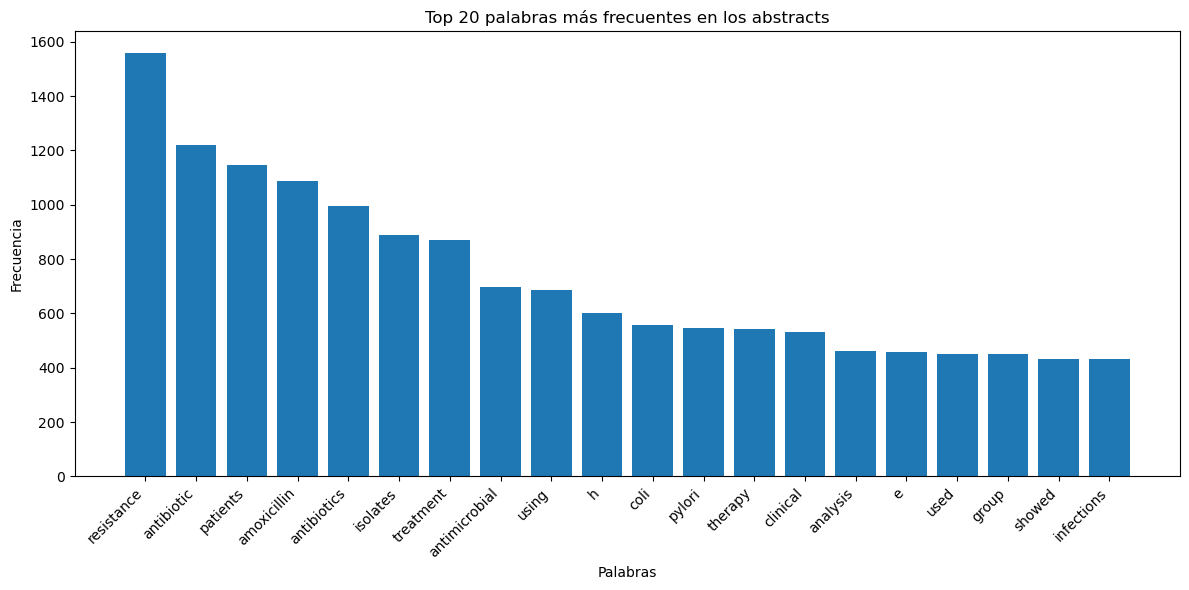

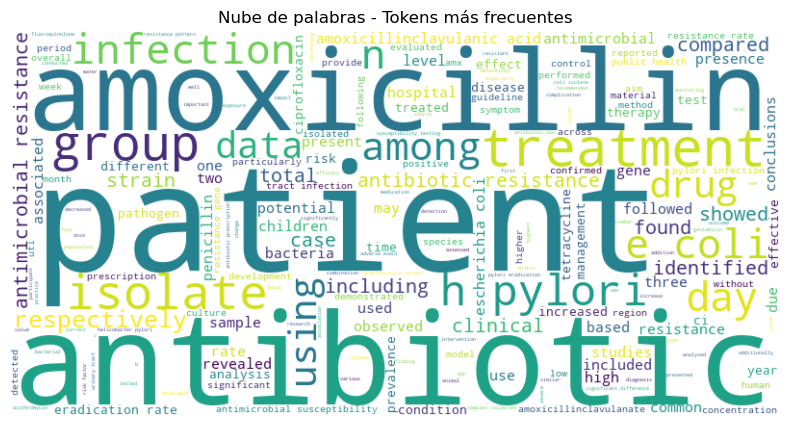

In [7]:
# grafico de barras de las palabras mas frecuentes
import matplotlib.pyplot as plt

# separar palabras y frecuencias
palabras, frecuencias = zip(*frecuentes)

# Crear gráfico
plt.figure(figsize=(12,6))
plt.bar(palabras, frecuencias)
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 palabras más frecuentes en los abstracts")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

from wordcloud import WordCloud

# crear string de todos los tokens
texto_completo = " ".join(todos_los_tokens)

# generar nube
nube = WordCloud(width=800, height=400, background_color='white').generate(texto_completo)

# mostrar
plt.figure(figsize=(10,5))
plt.imshow(nube, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras - Tokens más frecuentes")
plt.show()


## 8. Embeddings con BioBERT
Se utiliza el modelo BioBERT para transformar los resúmenes (abstracts) en vectores numéricos conocidos como embeddings. Estos vectores capturan el significado semántico de cada texto y pueden ser utilizados para tareas posteriores como clustering, búsqueda semántica o clasificación.

Carga del modelo y tokenizador
Se usa transformers de Hugging Face para cargar el modelo monologg/biobert_v1.1_pubmed. Se inicializa el tokenizador y el modelo, que se pone en modo evaluación (model.eval()).

Función para obtener el embedding
La función obtener_embedding procesa cada resumen, aplica el tokenizador y pasa los tokens al modelo. Se extrae el embedding asociado al token [CLS], que representa el significado global del texto. Si ocurre un error, devuelve un vector nulo para evitar interrupciones.

Procesamiento de abstracts
Se aplica la función a cada resumen del archivo abstracts_amoxicillin.csv, usando tqdm para mostrar el progreso. Se genera una lista de embeddings.

Guardar resultados
Los vectores se convierten en un DataFrame y se guardan en el archivo abstracts_biobert_embeddings.csv para uso posterior.



In [3]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained("monologg/biobert_v1.1_pubmed")
model = AutoModel.from_pretrained("monologg/biobert_v1.1_pubmed")
model.eval()  # Desactivar dropout

df = pd.read_csv("abstracts_amoxicillin.csv")

# obtener el embedding del token [CLS]
def obtener_embedding(texto):
    try:
        inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        return cls_embedding
    except:
        return [0.0] * model.config.hidden_size  # Vector nulo si hay error

# guardar embeddings
tqdm.pandas()
embeddings = df["abstract"].progress_apply(obtener_embedding)

# Convertir a DataFrame
df_embeddings = pd.DataFrame(embeddings.tolist())
df_embeddings.to_csv("abstracts_biobert_embeddings.csv", index=False)
print("Embeddings guardados en: abstracts_biobert_embeddings.csv")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 987/987 [06:02<00:00,  2.73it/s]


Embeddings guardados en: abstracts_biobert_embeddings.csv


In [4]:
# cargar archivo de embeddings
df_emb = pd.read_csv("abstracts_biobert_embeddings.csv")
print("Forma del archivo:", df_emb.shape)


Forma del archivo: (987, 768)


## 8.1 Normalización de Embeddings antes de PCA y t-SNE
Para mejorar la estabilidad y calidad de la visualización, se normalizan los vectores de BioBERT usando `StandardScaler`. Esto asegura que todas las dimensiones tengan media 0 y desviación estándar 1 antes de la reducción dimensional.


/Users/mac001/miniconda3/envs/tfm_jarrin/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


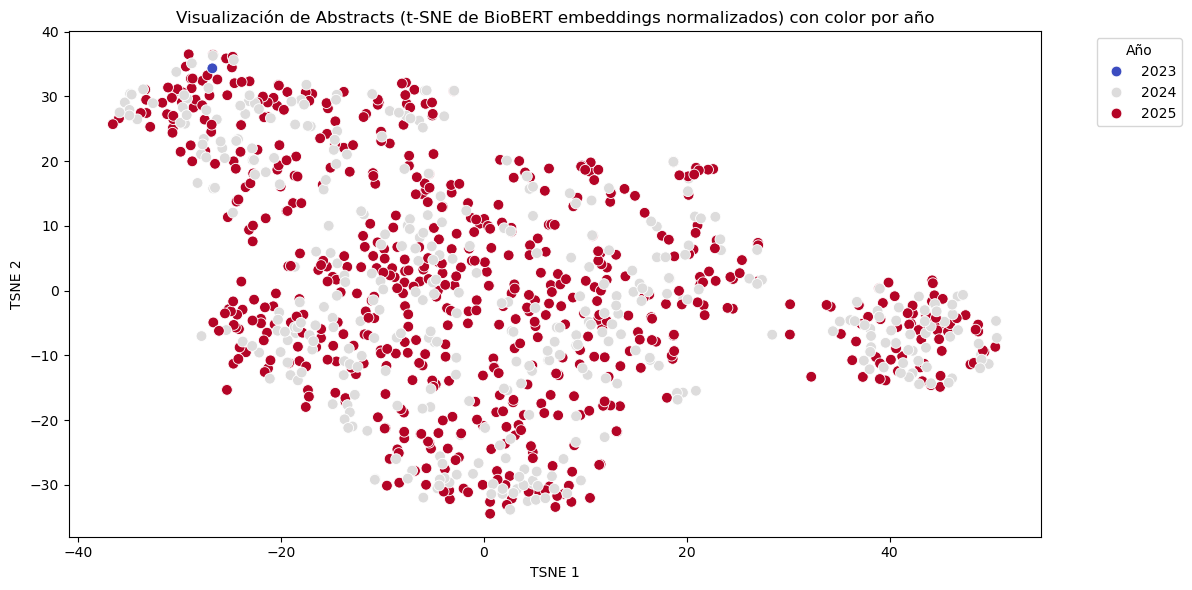

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Cargar los embeddings y los metadatos
df_emb = pd.read_csv("abstracts_biobert_embeddings.csv")
df_meta = pd.read_csv("abstracts_amoxicillin.csv")  # contiene las columnas 'PMID', 'year', 'abstract'

# Normalizar embeddings
scaler = StandardScaler()
X_norm = scaler.fit_transform(df_emb.values)

# PCA
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_norm)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# Combinar con metadatos
df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
df_tsne["year"] = df_meta["year"]

# Graficar con color por año
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="year", palette="coolwarm", s=60)
plt.title("Visualización de Abstracts (t-SNE de BioBERT embeddings normalizados) con color por año")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(title="Año", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 9. Reducción Dimensional y Visualización con t-SNE
Este bloque permite visualizar gráficamente los embeddings generados con BioBERT. Como cada resumen fue convertido en un vector de 768 dimensiones, se aplica una reducción dimensional en dos etapas para poder representarlos en 2D de forma comprensible.

Carga de datos
Se carga el archivo abstracts_biobert_embeddings.csv, que contiene los embeddings numéricos de los abstracts biomédicos.

Paso 1: Reducción con PCA
Se aplica PCA para reducir los vectores de 768 dimensiones a 50. Esto acelera el procesamiento posterior y elimina ruido.

Paso 2: Reducción con t-SNE
Se utiliza t-SNE, una técnica de reducción dimensional no lineal, para proyectar los vectores a un espacio de solo 2 dimensiones, preservando relaciones locales.

Visualización
Se crea un DataFrame con las coordenadas 2D y se grafica usando seaborn. El resultado es una nube de puntos donde cada punto representa un abstract biomédico, y la distancia entre puntos refleja su similitud semántica.

/Users/mac001/miniconda3/envs/tfm_jarrin/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


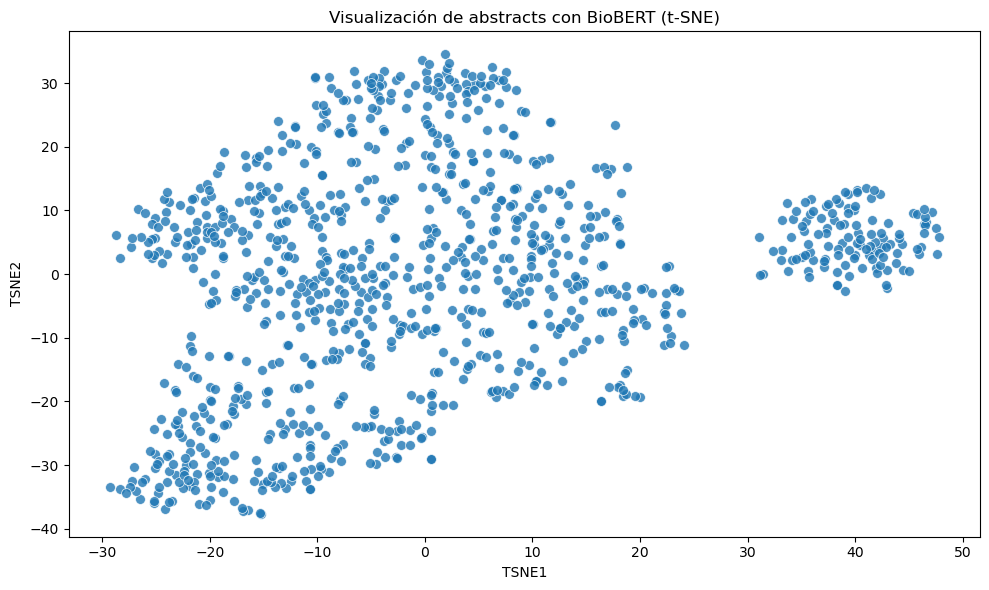

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("abstracts_biobert_embeddings.csv")

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(df.values)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])

plt.figure(figsize=(10, 6))
sns.scatterplot(x="TSNE1", y="TSNE2", data=df_tsne, s=50, alpha=0.8)
plt.title("Visualización de abstracts con BioBERT (t-SNE)")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.tight_layout()
plt.show()


## 10. Extracción de Entidades Biomédicas (NER) con spaCy + scispaCy
Se aplica Reconocimiento de Entidades Nombradas (NER) para identificar términos biomédicos clave (como enfermedades o compuestos químicos) dentro de los abstracts científicos.

Aunque inicialmente se intentó utilizar el modelo BioBERT para realizar NER, se presentaron incompatibilidades técnicas en el entorno que impidieron su correcta ejecución. Por ello, se optó por una alternativa robusta y optimizada para textos biomédicos: scispaCy, específicamente el modelo en_ner_bc5cdr_md, entrenado para identificar entidades de tipo CHEMICAL y DISEASE.

Carga del modelo NER
Se carga el modelo biomédico de spaCy para procesar los abstracts con reconocimiento de entidades.

Lectura del dataset
Se carga el archivo abstracts_amoxicillin.csv, que contiene los resúmenes descargados previamente de PubMed.

Función de extracción
Se define una función que recibe un texto, lo procesa con el modelo NER, y devuelve una lista de entidades encontradas junto con su tipo (etiqueta).

Procesamiento masivo
Se aplica la función a todos los abstracts, mostrando una barra de progreso con tqdm para hacer seguimiento del procesamiento.

Exportación de resultados
Los abstracts ahora tienen una nueva columna entidades con las entidades biomédicas extraídas. Se guarda un nuevo archivo: abstracts_amoxicillin_con_entidades.csv.

In [4]:
import scispacy
import spacy
import pandas as pd
from tqdm import tqdm

# cargar modelo "en_ner_bc5cdr_md"
nlp = spacy.load("en_ner_bc5cdr_md")

df = pd.read_csv("abstracts_amoxicillin.csv")

tqdm.pandas()

# detectar entidades
def extraer_entidades(texto):
    doc = nlp(str(texto))
    entidades = [(ent.text, ent.label_) for ent in doc.ents]
    return entidades

# aplica a cada abstract
df["entidades"] = df["abstract"].progress_apply(extraer_entidades)

# guardamos los resultados
df.to_csv("abstracts_amoxicillin_con_entidades.csv", index=False)
print("Entidades biomédicas extraídas y guardadas.")



/Users/mac001/miniconda3/envs/tfm_jarrin/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_ner_bc5cdr_md' (0.5.1) was trained with spaCy v3.4.1 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 987/987 [00:46<00:00, 21.44it/s]


Entidades biomédicas extraídas y guardadas.


## 11. Frecuencia de Entidades Biomédicas en Abstracts
Permite identificar las entidades más mencionadas en los resúmenes sobre amoxicilina, facilitando así el reconocimiento de patrones de interés como sustancias comunes, enfermedades relacionadas o términos clave.

Lectura de archivo
Se carga el archivo abstracts_amoxicillin_con_entidades.csv, previamente generado con scispaCy, que contiene entidades biomédicas extraídas por cada abstract.

Conversión de datos
Las entidades están almacenadas como cadenas con estructura de lista, por lo que se convierten a listas reales con literal_eval.

Unificación de entidades
Se combinan todas las listas de entidades en una única lista general, para facilitar el análisis de frecuencia.

Cálculo de frecuencia
Usando Counter de Python, se cuenta cuántas veces aparece cada entidad (considerando texto y tipo).

Preparación para análisis
Se construye un DataFrame con las entidades y sus frecuencias, separando además el texto y la etiqueta (CHEMICAL, DISEASE, etc.) en columnas distintas.

Visualización
Se imprimen las 10 entidades más frecuentes y se genera una gráfica de barras con matplotlib, permitiendo visualizar de forma clara cuáles son los términos más relevantes en el corpus de abstracts.

     Frecuencia           Texto  Etiqueta
12          908     amoxicillin  CHEMICAL
158         222             AMX  CHEMICAL
69          207      infections   DISEASE
27          179   ciprofloxacin  CHEMICAL
121         175       infection   DISEASE
35          169    tetracycline  CHEMICAL
23          152      ampicillin  CHEMICAL
47          145   metronidazole  CHEMICAL
17          141      penicillin  CHEMICAL
124         136  clarithromycin  CHEMICAL


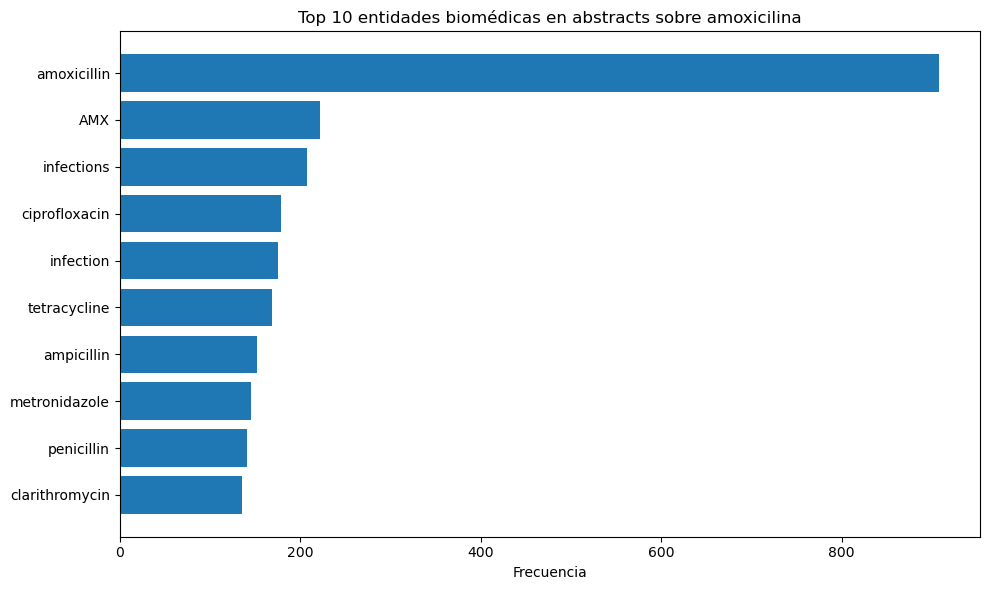

In [5]:
import pandas as pd
from ast import literal_eval
from collections import Counter
import matplotlib.pyplot as plt

df = pd.read_csv("abstracts_amoxicillin_con_entidades.csv")

df["entidades"] = df["entidades"].apply(literal_eval)

todas_entidades = [ent for lista in df["entidades"] for ent in lista]

frecuencias = Counter(todas_entidades)

df_frec = pd.DataFrame(frecuencias.items(), columns=["Entidad", "Frecuencia"])
df_frec[["Texto", "Etiqueta"]] = pd.DataFrame(df_frec["Entidad"].tolist(), index=df_frec.index)
df_frec = df_frec.drop(columns=["Entidad"])
df_frec = df_frec.sort_values(by="Frecuencia", ascending=False)

# mostrar las 10 entidades mas frecuentes
print(df_frec.head(10))

top = df_frec.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top["Texto"][::-1], top["Frecuencia"][::-1])
plt.xlabel("Frecuencia")
plt.title("Top 10 entidades biomédicas en abstracts sobre amoxicilina")
plt.tight_layout()
plt.show()


## 12. Relación entre Entidades: CHEMICAL y DISEASE
Este bloque tiene como objetivo analizar las relaciones que aparecen en los abstracts entre sustancias químicas (CHEMICAL) y enfermedades (DISEASE), para identificar posibles interacciones, efectos adversos o asociaciones clínicas comunes en el contexto de la amoxicilina.

1. Carga y limpieza de entidades
Se carga el archivo de entidades y se convierten los strings a listas de tuplas reales (literal_eval). Se eliminan las filas vacías o sin entidades válidas.

2. Expansión y separación
Cada entidad se separa en filas individuales. Luego, se divide en dos columnas: texto de la entidad y su etiqueta (CHEMICAL, DISEASE, etc.).

3. Filtrado por tipo de entidad
Se filtra el DataFrame para quedarse únicamente con las entidades etiquetadas como CHEMICAL o DISEASE.

4. Análisis de frecuencia individual
Se cuentan las 5 sustancias químicas y las 5 enfermedades más comunes por separado y se grafican con seaborn.

Gráfico 1: Top 5 sustancias químicas más mencionadas.

Gráfico 2: Top 5 enfermedades más mencionadas.

5. Asociación entre entidades por abstract
Por cada abstract, se generan pares entre cada sustancia química y cada enfermedad mencionada. Esto permite identificar posibles relaciones como:

Uso del químico para tratar la enfermedad.

Efectos adversos o interacción con la enfermedad.

6. Conteo y visualización de relaciones
Se cuentan las veces que aparece cada par (químico-enfermedad) en los abstracts. Luego:

Se crea un DataFrame de relaciones con sus frecuencias.

Se grafican las 5 relaciones más frecuentes usando etiquetas combinadas (CHEMICAL ↔ DISEASE).

/var/folders/yj/bjx2v2nj1nb5fxh8847gvy600000gn/T/ipykernel_5857/2288642655.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_chem, x="Frecuencia", y="CHEMICAL", palette="Blues_d")


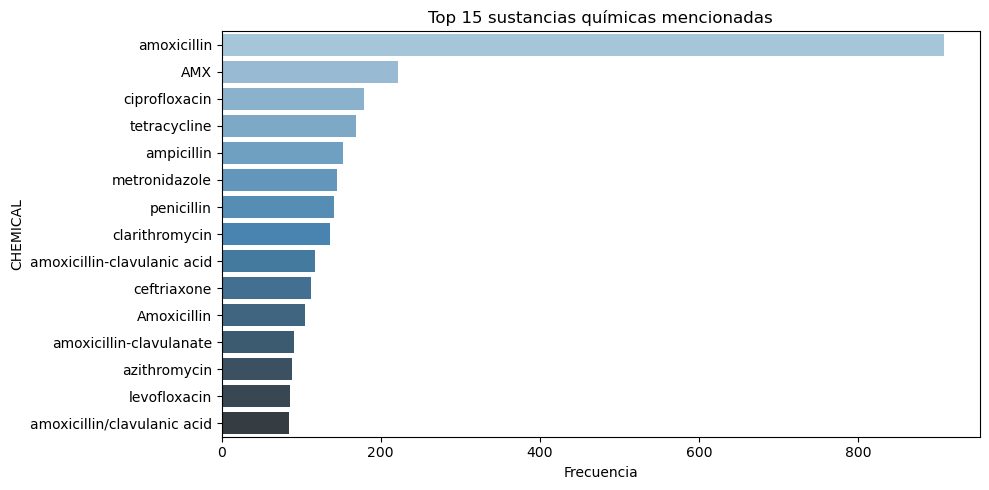

/var/folders/yj/bjx2v2nj1nb5fxh8847gvy600000gn/T/ipykernel_5857/2288642655.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_dis, x="Frecuencia", y="DISEASE", palette="Reds_d")


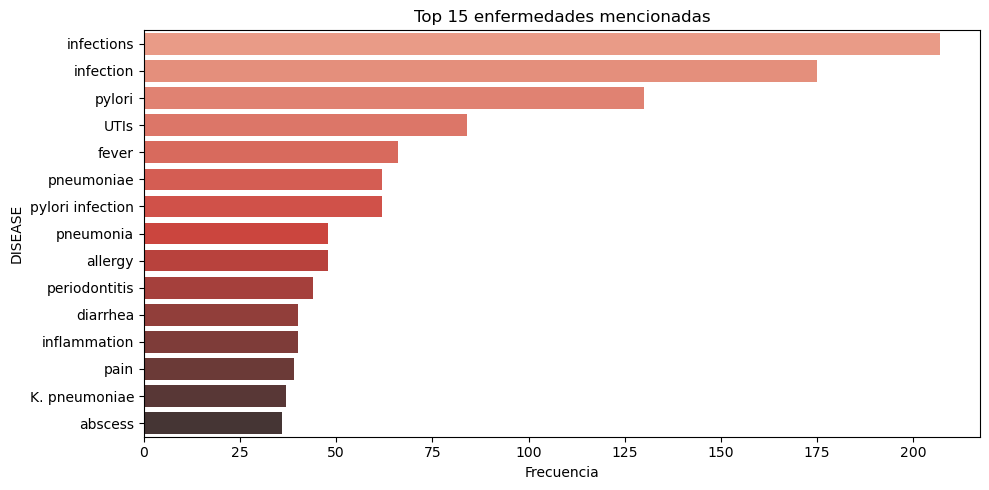

/var/folders/yj/bjx2v2nj1nb5fxh8847gvy600000gn/T/ipykernel_5857/2288642655.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


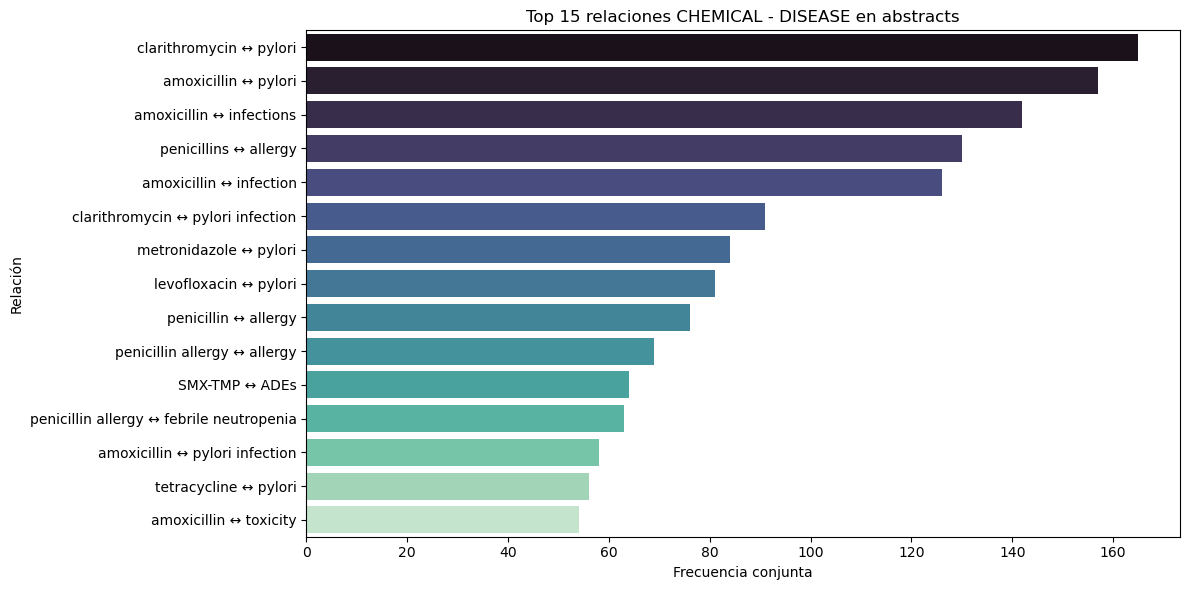

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval

# cargar csv con entidades
df = pd.read_csv("abstracts_amoxicillin_con_entidades.csv")

df["entidades"] = df["entidades"].apply(lambda x: literal_eval(str(x)) if isinstance(x, str) else x)

# se elimina na
df = df[df["entidades"].notna() & df["entidades"].apply(lambda x: isinstance(x, list) and len(x) > 0)]

df = df.explode("entidades")

# separamos texto y etiqueta
df[["Texto", "Etiqueta"]] = pd.DataFrame(df["entidades"].tolist(), index=df.index)
df.drop(columns=["entidades"], inplace=True)

# filtramos
df_chem = df[df["Etiqueta"] == "CHEMICAL"]
df_dis = df[df["Etiqueta"] == "DISEASE"]

# contmaos frecuencia las 15 entidades mas comunes
top_chem = df_chem["Texto"].value_counts().head(15).reset_index()
top_chem.columns = ["CHEMICAL", "Frecuencia"]

top_dis = df_dis["Texto"].value_counts().head(15).reset_index()
top_dis.columns = ["DISEASE", "Frecuencia"]

plt.figure(figsize=(10, 5))
sns.barplot(data=top_chem, x="Frecuencia", y="CHEMICAL", palette="Blues_d")
plt.title("Top 15 sustancias químicas mencionadas")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=top_dis, x="Frecuencia", y="DISEASE", palette="Reds_d")
plt.title("Top 15 enfermedades mencionadas")
plt.tight_layout()
plt.show()

# relacionar entidades y abstracts
df_grouped = df.groupby("abstract").agg(list).reset_index()
relaciones = []

for row in df_grouped.itertuples():
    chems = [e for e, l in zip(row.Texto, row.Etiqueta) if l == "CHEMICAL"]
    dises = [e for e, l in zip(row.Texto, row.Etiqueta) if l == "DISEASE"]
    for c in chems:
        for d in dises:
            relaciones.append((c, d))

# contamos relaciones mas frcuentes
df_rel = pd.DataFrame(relaciones, columns=["CHEMICAL", "DISEASE"])
df_relaciones = df_rel.value_counts().reset_index(name="Frecuencia")

# grafica
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_relaciones.head(15),
    x="Frecuencia",
    y=df_relaciones.head(15).apply(lambda x: f"{x['CHEMICAL']} ↔ {x['DISEASE']}", axis=1),
    palette="mako"
)
plt.title("Top 15 relaciones CHEMICAL - DISEASE en abstracts")
plt.xlabel("Frecuencia conjunta")
plt.ylabel("Relación")
plt.tight_layout()
plt.show()


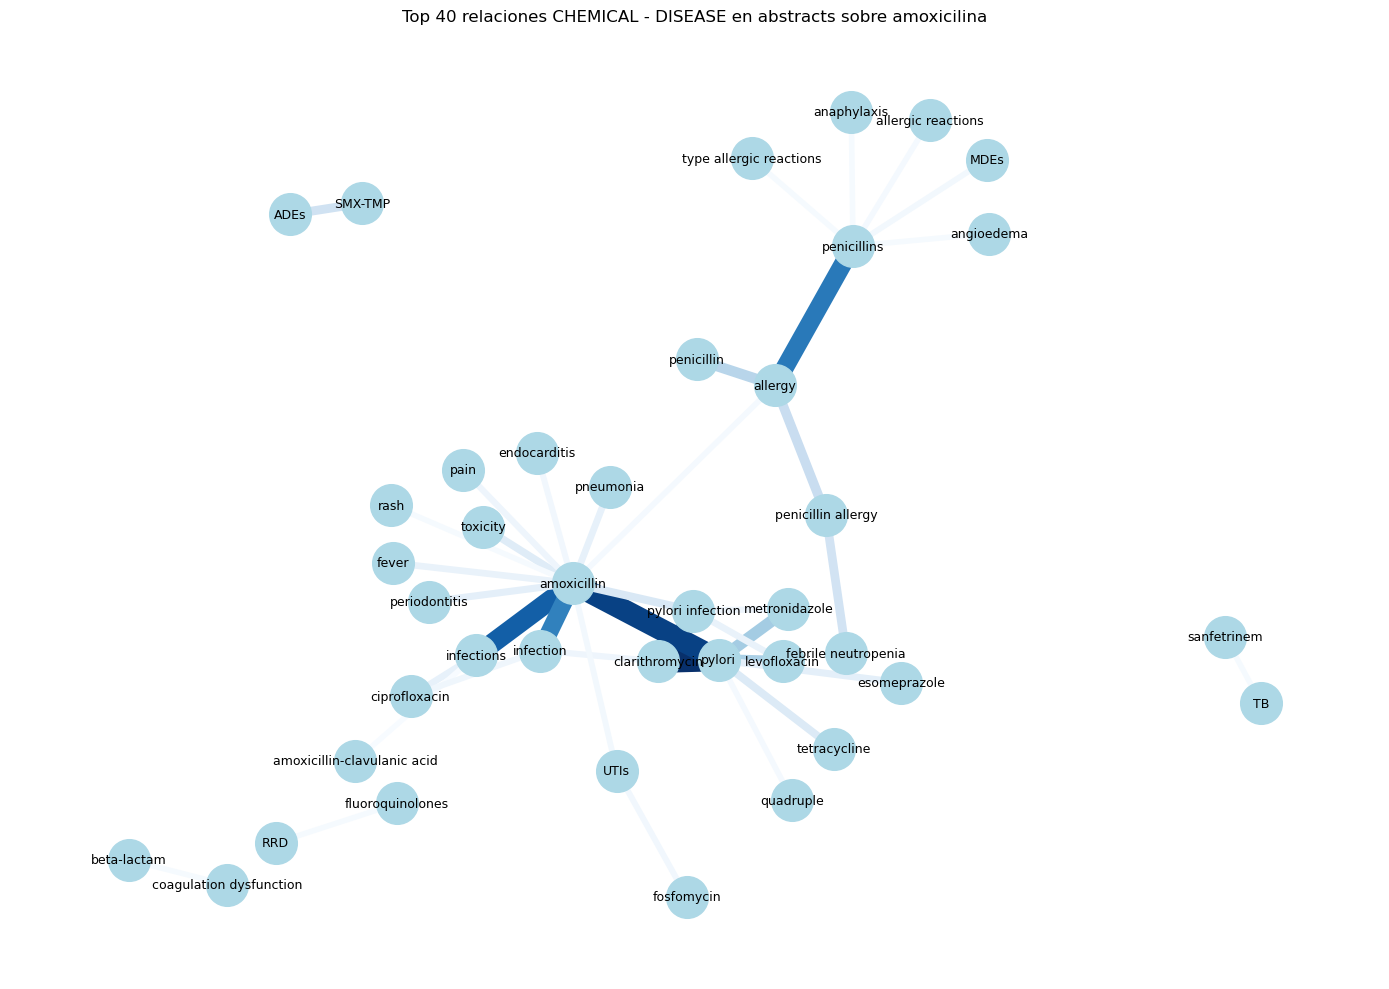

In [7]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from ast import literal_eval
import matplotlib.cm as cm
import matplotlib.colors as mcolors

df = pd.read_csv("abstracts_amoxicillin_con_entidades.csv")

# procesar entidades
df["entidades"] = df["entidades"].apply(lambda x: literal_eval(str(x)) if isinstance(x, str) else x)
df = df[df["entidades"].notna() & df["entidades"].apply(lambda x: isinstance(x, list) and len(x) > 0)]
df = df.explode("entidades")
df[["Texto", "Etiqueta"]] = pd.DataFrame(df["entidades"].tolist(), index=df.index)

# agrupamiento y relaciones
df_grouped = df.groupby("abstract").agg(list).reset_index()
relaciones = []

for row in df_grouped.itertuples():
    chems = [e for e, l in zip(row.Texto, row.Etiqueta) if l == "CHEMICAL"]
    dises = [e for e, l in zip(row.Texto, row.Etiqueta) if l == "DISEASE"]
    for c in chems:
        for d in dises:
            relaciones.append((c, d))

# conteo frecuencia y relaciones
df_rel = pd.DataFrame(relaciones, columns=["CHEMICAL", "DISEASE"])
df_relaciones = df_rel.value_counts().reset_index(name="Frecuencia")

# filtramos top 40
df_top = df_relaciones.head(40)

# grafico
G = nx.Graph()
for row in df_top.itertuples():
    G.add_edge(row.CHEMICAL, row.DISEASE, weight=row.Frecuencia)

# normalizamos colores
weights = [d['weight'] for (_, _, d) in G.edges(data=True)]
norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = cm.Blues
edge_colors = [cmap(norm(w)) for w in weights]


plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=1.2, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=900, node_color="lightblue")
nx.draw_networkx_labels(G, pos, font_size=9)

nx.draw_networkx_edges(
    G, pos,
    width=[w * 0.1 for w in weights],
    edge_color=edge_colors
)

plt.title("Top 40 relaciones CHEMICAL - DISEASE en abstracts sobre amoxicilina")
plt.axis("off")
plt.tight_layout()
plt.show()




In [1]:
import spacy
import pandas as pd
from tqdm import tqdm

# Cargar modelo biomédico de SciSpaCy
nlp = spacy.load("en_ner_bc5cdr_md")

# Palabras clave por tipo de relación
palabras_clave = {
    "causa": ["cause", "induced", "trigger", "due to", "resulted in", "associated with"],
    "efecto_adverso": ["adverse", "rash", "toxicity", "anaphylaxis", "reaction", "hypersensitivity"],
    "comparación": ["compared", "versus", "vs", "similar to", "more effective than"],
    "tratamiento": ["treats", "prevents", "effective for", "used for", "administered"]
}

# Función para clasificar tipo de relación por palabras clave
def clasificar_relacion(sentencia):
    texto = sentencia.lower()
    for tipo, keywords in palabras_clave.items():
        if any(kw in texto for kw in keywords):
            return tipo
    return "otro"

# Función para extraer relaciones con contexto
def extraer_relaciones_contextuales(texto):
    doc = nlp(texto)
    relaciones = []
    for sent in doc.sents:
        chems = [ent.text for ent in sent.ents if ent.label_ == "CHEMICAL"]
        dises = [ent.text for ent in sent.ents if ent.label_ == "DISEASE"]
        tipo = clasificar_relacion(sent.text)
        for c in chems:
            for d in dises:
                relaciones.append((c, d, tipo, sent.text))
    return relaciones

# Aplicar a los abstracts
df = pd.read_csv("abstracts_amoxicillin.csv")
tqdm.pandas()
df["relaciones_contexto"] = df["abstract"].progress_apply(extraer_relaciones_contextuales)

# Expandir y guardar resultados
relaciones_planas = [rel for lista in df["relaciones_contexto"] for rel in lista]
df_relaciones = pd.DataFrame(relaciones_planas, columns=["CHEMICAL", "DISEASE", "relación", "oración"])
df_relaciones.to_csv("relaciones_contextuales_amoxicilina.csv", index=False)
print("✅ Relaciones semánticas extraídas y guardadas.")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 987/987 [00:46<00:00, 21.42it/s]


✅ Relaciones semánticas extraídas y guardadas.


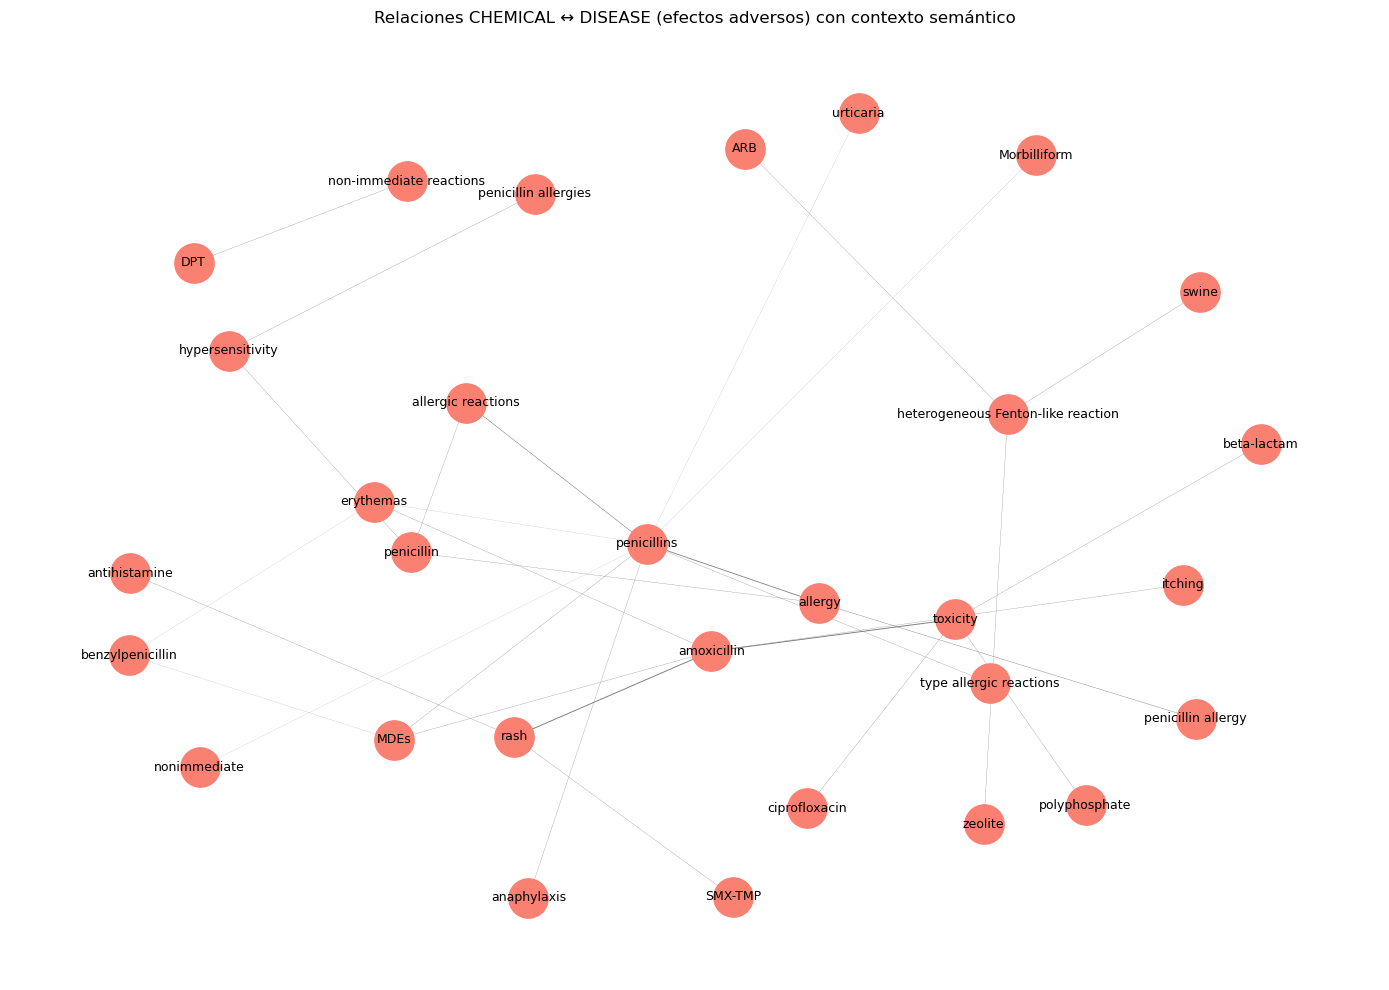

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Cargar las relaciones extraídas
df_relaciones = pd.read_csv("relaciones_contextuales_amoxicilina.csv")

# Filtrar solo relaciones tipo "efecto_adverso"
df_adversos = df_relaciones[df_relaciones["relación"] == "efecto_adverso"]

# Contar frecuencias de cada par CHEMICAL ↔ DISEASE
conteo = Counter([(row["CHEMICAL"], row["DISEASE"]) for _, row in df_adversos.iterrows()])
top_relaciones = conteo.most_common(30)  # top 30 más frecuentes

# Crear grafo
G = nx.Graph()
for (chem, dis), peso in top_relaciones:
    G.add_edge(chem, dis, weight=peso)

# Visualizar
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=1.2, seed=42)
pesos = [d["weight"] for (_, _, d) in G.edges(data=True)]

nx.draw_networkx_nodes(G, pos, node_color="salmon", node_size=800)
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edges(G, pos, width=[w * 0.1 for w in pesos], edge_color="gray")

plt.title("Relaciones CHEMICAL ↔ DISEASE (efectos adversos) con contexto semántico")
plt.axis("off")
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
from tqdm import tqdm

# Cargar relaciones
df = pd.read_csv("relaciones_contextuales_amoxicilina.csv")
df = df[df["relación"] != "otro"].copy()  # filtramos relaciones informativas

# Función para generar interpretación basada en tipo de relación
def interpretar_por_plantilla(chemical, disease, tipo, oracion):
    if tipo == "efecto_adverso":
        return f"{chemical} has been associated with the adverse effect {disease}, as indicated in the sentence: \"{oracion.strip()}\". This suggests a potential risk of {disease} when using {chemical}."
    elif tipo == "causa":
        return f"The text suggests that {chemical} may cause or trigger {disease}, highlighting a possible causative association: \"{oracion.strip()}\"."
    elif tipo == "comparación":
        return f"{chemical} is mentioned in comparative context with {disease}, possibly in terms of efficacy or safety: \"{oracion.strip()}\"."
    elif tipo == "tratamiento":
        return f"{chemical} appears to be used in the context of treating or preventing {disease}, according to: \"{oracion.strip()}\"."
    else:
        return f"A connection between {chemical} and {disease} is observed in: \"{oracion.strip()}\"."

# Aplicar función
tqdm.pandas()
df["interpretacion"] = df.progress_apply(
    lambda row: interpretar_por_plantilla(row["CHEMICAL"], row["DISEASE"], row["relación"], row["oración"]),
    axis=1
)

# Guardar resultados
df.to_csv("relaciones_interpretadas_transformers.csv", index=False)
print("✅ Interpretaciones generadas y guardadas en 'relaciones_interpretadas_transformers.csv'")

# Mostrar muestra
df[["CHEMICAL", "DISEASE", "relación", "interpretacion"]].head(5)




100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 684/684 [00:00<00:00, 46881.35it/s]

✅ Interpretaciones generadas y guardadas en 'relaciones_interpretadas_transformers.csv'


,CHEMICAL,DISEASE,relación,interpretacion
14,ceftriaxone,hypotension,causa,The text suggests that ceftriaxone may cause o...
15,ceftriaxone,sepsis,causa,The text suggests that ceftriaxone may cause o...
16,metronidazole,hypotension,causa,The text suggests that metronidazole may cause...
17,metronidazole,sepsis,causa,The text suggests that metronidazole may cause...
18,piperacillin-tazobactam,liver abscess,causa,The text suggests that piperacillin-tazobactam...
